# ДЗ №1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image

In [2]:
class Point:
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __str__(self):
        return "Point(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        return isinstance(other, self.__class__) and self.x == getattr(other, "x", None) and self.y == getattr(other, "y", None)

    def __ne__(self, other):
        return not (self == other)

    def get_dist_to_point(self, point):
        return math.sqrt(pow(self.x - point.x, 2) + pow(self.y - point.y, 2))

In [3]:
class Edge:
    def __init__(self, p1, p2):
        self.p1, self.p2 = p1, p2

    def __str__(self):
        return "Edge(" + str(self.p1) + ", " + str(self.p2) + ")"
    
    def __hash__(self):
        return hash(hash(str(self.p1)) + hash(str(self.p2)))

    def __eq__(self, other):
        return isinstance(other, self.__class__) and \
            (self.p1 == getattr(other, "p1", None) and self.p2 == getattr(other, "p2", None)) or \
            (self.p1 == getattr(other, "p2", None) and self.p2 == getattr(other, "p1", None))

    def __ne__(self, other):
        return not (self == other)

In [4]:
class Circle:
    def __init__(self, center_point, radius):
        self.center_point, self.radius = center_point, radius

    def contains_point(self, point):
        return point.get_dist_to_point(self.center_point) <= self.radius

In [5]:
class Triangle:
    def __init__(self, p1, p2, p3):
        self.p1, self.p2, self.p3 = p1, p2, p3

    def __str__(self):
        return "Triangle(" + str(self.p1) + ", " + str(self.p2) + ", " + str(self.p3) + ")"

    def __eq__(self, other):
        return isinstance(other, self.__class__) and \
            self.p1 == getattr(other, "p1", None) and \
            self.p2 == getattr(other, "p2", None) and \
            self.p3 == getattr(other, "p3", None)

    def __ne__(self, other):
        return not (self == other)

    def get_points(self):
        return [self.p1, self.p2, self.p3]

    def get_edges(self):
        return [Edge(self.p1, self.p2), Edge(self.p2, self.p3), Edge(self.p3, self.p1)]

    def get_circumscribed_circle(self):
        z = []
        for point in self.get_points():
            z.append(point.x * point.x + point.y * point.y)

        z_x = (self.p1.y - self.p2.y) * z[2] + (self.p2.y - self.p3.y) * z[0] + (self.p3.y - self.p1.y) * z[1]
        z_y = (self.p1.x - self.p2.x) * z[2] + (self.p2.x - self.p3.x) * z[0] + (self.p3.x - self.p1.x) * z[1]
        z = (self.p1.x - self.p2.x) * (self.p3.y - self.p1.y) - (self.p1.y - self.p2.y) * (self.p3.x - self.p1.x)

        a = -z_x / (2 * z)
        b = z_y / (2 * z)
        point = Point(a, b)
        return Circle(point, point.get_dist_to_point(self.p1))

    def draw(self, ax):
        x = [self.p1[0], self.p2[0], self.p3[0]]
        y = [self.p1[1], self.p2[1], self.p3[1]]
        z = [self.p1[2], self.p2[2], self.p3[2]]
        vertices = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(vertices, edgecolors='r', lw=2, alpha=0.2, linestyles='--'))

In [6]:
def delaunay_triangulation(source_points, dist):
    points = set(source_points)

    if len(points) == 0:
        return []
    
    # Находим минимальные и максимальные значения координат
    x_min, x_max, y_min, y_max = None, None, None, None
    for point in points:
        if x_min is None or x_min > point.x:
            x_min = point.x
        if x_max is None or x_max < point.x:
            x_max = point.x
        if y_min is None or y_min > point.y:
            y_min = point.y
        if y_max is None or y_max < point.y:
            y_max = point.y
    # Ограничивающая рамка расширяется путем добавления/вычитания значения dist
    x_min -= dist
    y_min -= dist
    x_max += dist
    y_max += dist
    
    # Создаем начальные треугольники
    # Два начальных треугольника созданы с использованием углов ограничивающей рамки
    triangles = [
        Triangle(Point(x_min, y_max), Point(x_min, y_min), Point(x_max, y_min)),
        Triangle(Point(x_min, y_max), Point(x_max, y_max), Point(x_max, y_min)),
    ]
    
    # Добавляем новые точки по правилу удаляй и строй
    # Если новая точка попадает в окружность треугольника, треугольник помечается как "плохой треугольник", 
    # а его края помечаются как "плохие ребра". Плохие треугольники удаляются из списка
    # Новые треугольники создаются путем соединения новой точки с ребрами плохих треугольников, которые имеют только 1 вхождение в словаре плохих ребер (т.е. это не смежное ребро)
    for new_point in points:
        bad_triangles = []
        bad_edges = {}
        for triangle in triangles:
            circle = triangle.get_circumscribed_circle()
            # Проверяем, лежит ли новая точка в окружности, описанной вокруг треугольника
            if circle.contains_point(new_point):
                bad_triangles.append(triangle)
                # Запоминаем плохие ребра, которые будут удалены
                for bad_triangle_edge in triangle.get_edges():
                    bad_edges[bad_triangle_edge] = bad_edges.get(bad_triangle_edge, 0) + 1
        
        # Удаляем плохие треугольники
        for bad_triangle in bad_triangles:
            triangles.remove(bad_triangle)
        
        # Строим новые треугольники
        for bad_edge in bad_edges:
            if bad_edges[bad_edge] > 1:
                continue
            new_triangle = Triangle(new_point, bad_edge.p1, bad_edge.p2)
            triangles.append(new_triangle)

    return triangles

In [7]:
im = Image.open('img1.jpg').convert('L').crop((700, 300, 1500, 1000))
# im.show()
im_array = np.array(im)
im_array = im_array.astype(float) / 255

def avg_height(y, x):
    eps = 40
    return im_array[max(x - eps, 0):min(x + eps, height), max(y - eps, 0):min(y + eps, width)].mean()

mountaint_height = 5642
point_count = 1500
random_points = True
width, height = im.size

dist = 1 # значение расстояния, используемое для расширения ограничивающей рамки
source_points = []

if random_points:
    for i in range(point_count):
        random_x = np.random.randint(0, width - 1)
        random_y = np.random.randint(0, height - 1)
        source_points.append(Point(random_x, random_y))

delaunay_triangles = delaunay_triangulation(source_points, dist)

triangles = []
for triangle in delaunay_triangles:
    p1, p2, p3 = triangle.p1, triangle.p2, triangle.p3
    z1, z2, z3 = avg_height(p1.x, p1.y) * mountaint_height, avg_height(p2.x, p2.y) * mountaint_height, avg_height(p3.x, p3.y) * mountaint_height

    triangles.append([(p1.x, p2.x, p3.x), (p1.y, p2.y, p3.y), (z1, z2, z3)])

for triangle in delaunay_triangles:
    print(triangle)

Triangle(Point(167, 186), Point(170, 212), Point(137, 216))
Triangle(Point(92, 672), Point(96, 657), Point(115, 686))
Triangle(Point(476, 636), Point(480, 645), Point(490, 629))
Triangle(Point(597, 598), Point(604, 590), Point(590, 571))
Triangle(Point(559, 129), Point(536, 103), Point(562, 128))
Triangle(Point(787, 668), Point(799, 699), Point(794, 645))
Triangle(Point(769, 149), Point(780, 146), Point(772, 151))
Triangle(Point(23, 651), Point(12, 653), Point(17, 631))
Triangle(Point(36, 210), Point(38, 195), Point(59, 203))
Triangle(Point(534, 678), Point(503, 665), Point(528, 687))
Triangle(Point(297, 421), Point(301, 396), Point(315, 414))
Triangle(Point(550, 578), Point(548, 603), Point(560, 584))
Triangle(Point(280, 478), Point(303, 498), Point(285, 510))
Triangle(Point(577, 463), Point(584, 462), Point(580, 467))
Triangle(Point(304, 332), Point(328, 325), Point(314, 346))
Triangle(Point(377, 664), Point(400, 675), Point(414, 642))
Triangle(Point(199, 418), Point(172, 394), Point

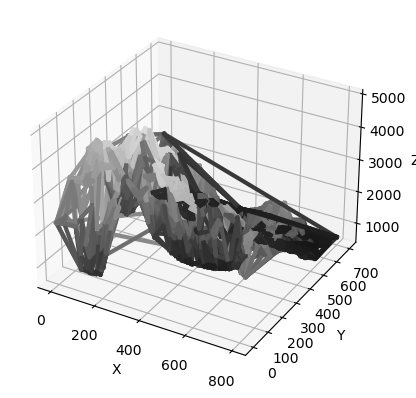

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=3, gapcolor=str(color))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# elev = 30.0
# azim = 10.5
# ax.view_init(elev, azim)

plt.show()

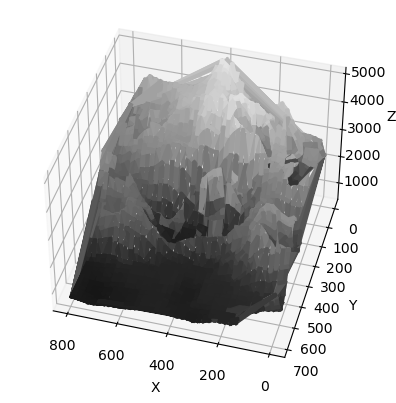

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=3, gapcolor=str(color))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

elev = 42.0
azim = 105.5
ax.view_init(elev, azim)

# Show the figure, adjust it with the mouse
plt.show()

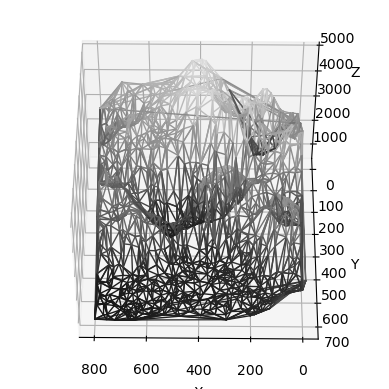

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# If we knew what angles we wanted to set, these lines will set it
elev = 50.0
azim = 90.5
ax.view_init(elev, azim)

# Show the figure, adjust it with the mouse
plt.show()

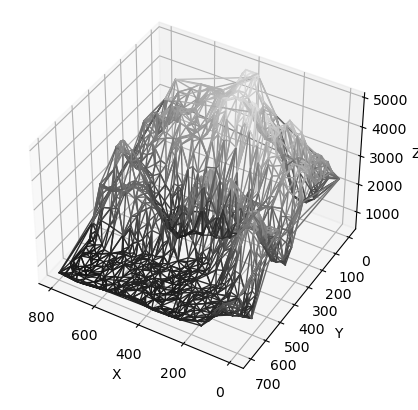

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# If we knew what angles we wanted to set, these lines will set it
elev = 40.0
azim = 120.5
ax.view_init(elev, azim)

# Show the figure, adjust it with the mouse
plt.show()

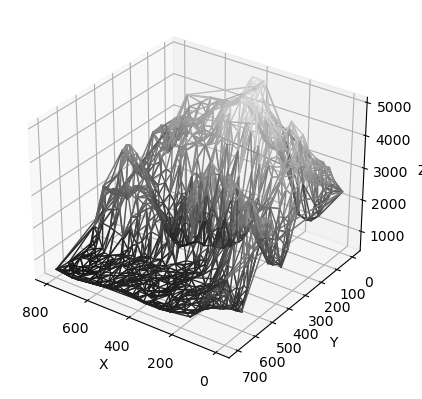

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# If we knew what angles we wanted to set, these lines will set it
elev = 30.0
azim = 125.5
ax.view_init(elev, azim)

# Show the figure, adjust it with the mouse
plt.show()

964.9921921568625


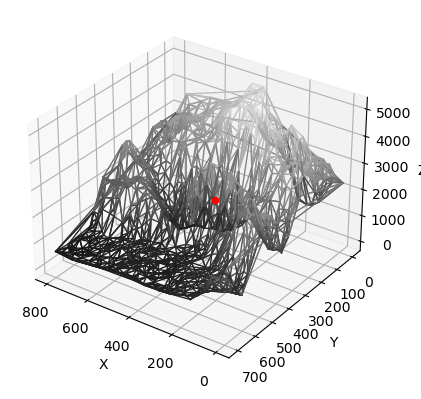

In [42]:
xx1 = 600
yy1 = 10

zz1 = avg_height(yy1, xx1)
print(zz1 * mountaint_height)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

ax.scatter(xx1, yy1, zz1, color='red')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

elev = 30.0
azim = 125.5
ax.view_init(elev, azim)

plt.show()

1700.4653419416547


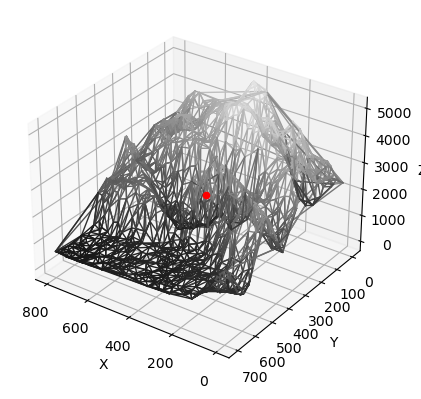

In [20]:
xx1 = 650
yy1 = 1

zz1 = avg_height(yy1, xx1)
print(zz1 * mountaint_height)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

ax.scatter(xx1, yy1, zz1, color='red')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

elev = 30.0
azim = 125.5
ax.view_init(elev, azim)

plt.show()

5641.94358


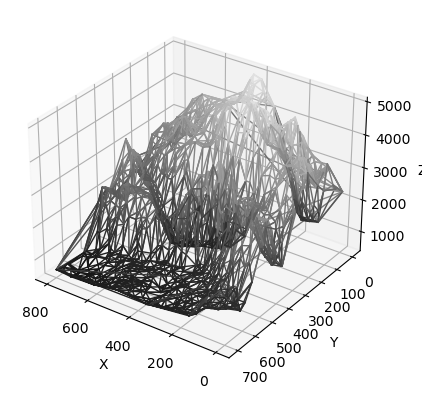

In [10]:
xx1 = 600
yy1 = 10

zz1 = 0.99999
print(zz1 * mountaint_height)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for triangle in triangles:
    color = np.mean(triangle[2])/5642.0
    ax.plot(*triangle, color=str(color), linewidth=1, gapcolor=str(color))

# ax.scatter(xx1, yy1, zz1, color='red')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

elev = 30.0
azim = 125.5
ax.view_init(elev, azim)

plt.show()